In [3]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 对 CNN / MLP 都有一点加速
torch.backends.cudnn.benchmark = True


Using device: cpu


In [7]:
# ==== 路径按你的文件名来 ====
wind_path  = "ERA5_TropicalPacific_Wind_Monthly_1980_2018.nc"
sst_path   = "SST_TropicalPacific_1980_2020 (1).nc"
pco2_path  = "pCO2_TropicalPacific_1980_2020.nc"
flux_path  = "fgco2_TropicalPacific_1980_2020.nc"

# ==== 读取风速 ====
ds_wind = xr.open_dataset(wind_path)
# wind 的坐标是 latitude / longitude，把名字改成 lat / lon，和 fgco2 一致
ds_wind = ds_wind.rename({"latitude": "lat", "longitude": "lon"})
wind = ds_wind["wind_speed"]   # (time, lat, lon)

print(ds_wind)

# ==== 读取 SST ====
ds_sst = xr.open_dataset(sst_path)
ds_sst = ds_sst.rename({"latitude": "lat", "longitude": "lon"})
sst = ds_sst["sst"]            # (time, lat, lon)

print(ds_sst)

# ==== 读取 pCO2 ====
ds_p = xr.open_dataset(pco2_path)
# pCO2 文件本来坐标就是 lat / lon，不需要改
p_ocean = ds_p["pco2_sea"]
p_air   = ds_p["pco2_air"]
dpco2   = p_ocean - p_air      # ΔpCO2 = 海水 - 大气
dpco2.name = "dpco2"

print(ds_p)

# ==== 读取 fgco2 ====
ds_flux = xr.open_dataset(flux_path)
flux = ds_flux["fgco2"]        # (time, lat, lon)

print(ds_flux)


<xarray.Dataset> Size: 539MB
Dimensions:     (time: 468, lat: 189, lon: 761)
Coordinates:
  * time        (time) datetime64[ns] 4kB 1980-01-01 1980-02-01 ... 2018-12-01
  * lat         (lat) float32 756B 23.5 23.25 23.0 22.75 ... -23.0 -23.25 -23.5
  * lon         (lon) float32 3kB 100.0 100.2 100.5 100.8 ... 289.5 289.8 290.0
Data variables:
    wind_speed  (time, lat, lon) float64 538MB ...
<xarray.Dataset> Size: 19MB
Dimensions:  (time: 492, lat: 48, lon: 200)
Coordinates:
  * time     (time) datetime64[ns] 4kB 1980-01-16T12:00:00 ... 2020-12-16T12:...
  * lat      (lat) float32 192B 23.5 22.5 21.5 20.5 ... -20.5 -21.5 -22.5 -23.5
  * lon      (lon) float32 800B 100.5 101.5 102.5 103.5 ... 297.5 298.5 299.5
Data variables:
    sst      (time, lat, lon) float32 19MB ...


sh: 1: Syntax error: "(" unexpected


<xarray.Dataset> Size: 76MB
Dimensions:   (time: 492, lat: 48, lon: 200)
Coordinates:
  * time      (time) datetime64[ns] 4kB 1980-01-15 1980-02-15 ... 2020-12-15
  * lat       (lat) float64 384B -23.5 -22.5 -21.5 -20.5 ... 20.5 21.5 22.5 23.5
  * lon       (lon) float64 2kB 100.5 101.5 102.5 103.5 ... 297.5 298.5 299.5
Data variables:
    pco2_sea  (time, lat, lon) float64 38MB ...
    pco2_air  (time, lat, lon) float64 38MB ...
Attributes:
    description:  Tropical Pacific (100E–280E, 23.5S–23.5N), monthly, 1980–2020
    source:       Derived from LDEO-HPD v2023 (Lamont-Doherty Earth Observatory)
<xarray.Dataset> Size: 38MB
Dimensions:  (time: 492, lat: 48, lon: 200)
Coordinates:
  * time     (time) datetime64[ns] 4kB 1980-01-15 1980-02-15 ... 2020-12-15
  * lat      (lat) float64 384B -23.5 -22.5 -21.5 -20.5 ... 20.5 21.5 22.5 23.5
  * lon      (lon) float64 2kB 100.5 101.5 102.5 103.5 ... 297.5 298.5 299.5
Data variables:
    fgco2    (time, lat, lon) float64 38MB ...
Attributes:


In [8]:
import numpy as np

print("wind time :", str(wind.time.min().values)[:10], "->", str(wind.time.max().values)[:10])
print("sst  time :", str(sst.time.min().values)[:10],  "->", str(sst.time.max().values)[:10])
print("dpco2 time:", str(dpco2.time.min().values)[:10],"->", str(dpco2.time.max().values)[:10])
print("flux time :", str(flux.time.min().values)[:10], "->", str(flux.time.max().values)[:10])

# 统一选 1980-02 到 2018-12
t0 = np.datetime64("1980-02-01")
t1 = np.datetime64("2018-12-31")

wind_c  = wind.sel(time=slice(t0, t1))
sst_c   = sst.sel(time=slice(t0, t1))
dpco2_c = dpco2.sel(time=slice(t0, t1))
flux_c  = flux.sel(time=slice(t0, t1))

print("after slice wind :", str(wind_c.time.min().values)[:10],  "->", str(wind_c.time.max().values)[:10])
print("after slice sst  :", str(sst_c.time.min().values)[:10],   "->", str(sst_c.time.max().values)[:10])
print("after slice dpco2:", str(dpco2_c.time.min().values)[:10], "->", str(dpco2_c.time.max().values)[:10])
print("after slice flux :", str(flux_c.time.min().values)[:10],  "->", str(flux_c.time.max().values)[:10])


wind time : 1980-01-01 -> 2018-12-01
sst  time : 1980-01-16 -> 2020-12-16
dpco2 time: 1980-01-15 -> 2020-12-15
flux time : 1980-01-15 -> 2020-12-15
after slice wind : 1980-02-01 -> 2018-12-01
after slice sst  : 1980-02-15 -> 2018-12-16
after slice dpco2: 1980-02-15 -> 2018-12-15
after slice flux : 1980-02-15 -> 2018-12-15


In [9]:
# 把所有变量都插值到 fgco2 的网格 (time, lat, lon)
wind_i  = wind_c.interp (time=flux_c.time, lat=flux_c.lat, lon=flux_c.lon)
sst_i   = sst_c.interp  (time=flux_c.time, lat=flux_c.lat, lon=flux_c.lon)
dpco2_i = dpco2_c.interp(time=flux_c.time, lat=flux_c.lat, lon=flux_c.lon)

print("wind_i shape :", wind_i.shape)
print("sst_i  shape :", sst_i.shape)
print("dpco2_i shape:", dpco2_i.shape)
print("flux_c shape :", flux_c.shape)


wind_i shape : (467, 48, 200)
sst_i  shape : (467, 48, 200)
dpco2_i shape: (467, 48, 200)
flux_c shape : (467, 48, 200)


In [10]:
# 合成一个多变量 Dataset
ds_all = xr.Dataset(
    {
        "wind":  wind_i,
        "sst":   sst_i,
        "dpco2": dpco2_i,
        "fgco2": flux_c,
    }
)

df_all = ds_all.to_dataframe().reset_index()

# 删掉有 NaN 的点（边缘插值可能有少量 NaN）
df_all = df_all.dropna(subset=["wind", "sst", "dpco2", "fgco2"])

print(df_all.head())
print("Total samples:", df_all.shape)


        time   lat    lon      wind        sst      dpco2     fgco2
0 1980-02-15 -23.5  100.5  8.257028  24.326971 -10.971371 -0.670731
1 1980-02-15 -23.5  101.5  8.223000  24.311869  -9.806672 -0.607181
2 1980-02-15 -23.5  102.5  8.230877  24.319754  -8.402887 -0.523545
3 1980-02-15 -23.5  103.5  8.272032  24.471025  -6.093933 -0.383561
4 1980-02-15 -23.5  104.5  8.173303  24.767303  -3.849811 -0.241710
Total samples: (3388752, 7)


In [11]:
# 确保 time 是 datetime 类型
df_all["time"] = pd.to_datetime(df_all["time"])

# 按年份切分
train_df = df_all[(df_all["time"] >= "1980-01-01") & (df_all["time"] < "2011-01-01")]
val_df   = df_all[(df_all["time"] >= "2011-01-01") & (df_all["time"] < "2016-01-01")]
test_df  = df_all[(df_all["time"] >= "2016-01-01") & (df_all["time"] <= "2018-12-31")]

print("Train samples:", len(train_df))
print("Val samples:  ", len(val_df))
print("Test samples: ", len(test_df))


Train samples: 2697912
Val samples:   436320
Test samples:  254520


In [12]:
# 三个自变量：风速 / SST / ΔpCO2
feature_cols = ["wind", "sst", "dpco2"]

X_train = train_df[feature_cols].values.astype("float32")
y_train = train_df[["fgco2"]].values.astype("float32")

X_val   = val_df[feature_cols].values.astype("float32")
y_val   = val_df[["fgco2"]].values.astype("float32")

X_test  = test_df[feature_cols].values.astype("float32")
y_test  = test_df[["fgco2"]].values.astype("float32")

print("X_train / y_train:", X_train.shape, y_train.shape)
print("X_val   / y_val  :", X_val.shape,   y_val.shape)
print("X_test  / y_test :", X_test.shape,  y_test.shape)


X_train / y_train: (2697912, 3) (2697912, 1)
X_val   / y_val  : (436320, 3) (436320, 1)
X_test  / y_test : (254520, 3) (254520, 1)


In [13]:
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

# 1. 标准化
scaler_X = StandardScaler()
X_train_s = scaler_X.fit_transform(X_train)
X_val_s   = scaler_X.transform(X_val)
X_test_s  = scaler_X.transform(X_test)

# 2. 转成 torch.Tensor
X_train_t = torch.from_numpy(X_train_s)
y_train_t = torch.from_numpy(y_train)

X_val_t   = torch.from_numpy(X_val_s)
y_val_t   = torch.from_numpy(y_val)

X_test_t  = torch.from_numpy(X_test_s)
y_test_t  = torch.from_numpy(y_test)

# 3. DataLoader
batch_size = 2048

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t,   y_val_t)
test_ds  = TensorDataset(X_test_t,  y_test_t)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)


In [14]:
class MultiVar_MLP(nn.Module):
    def __init__(self, in_dim=3, hidden1=32, hidden2=16, out_dim=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, out_dim),
        )

    def forward(self, x):
        return self.net(x)

# 初始化模型 / 损失函数 / 优化器
model_mv = MultiVar_MLP(in_dim=len(feature_cols)).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_mv.parameters(), lr=1e-3)

model_mv

MultiVar_MLP(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [15]:
num_epochs = 50

train_losses = []
val_losses   = []

for epoch in range(num_epochs):
    # ---- 训练阶段 ----
    model_mv.train()
    batch_train_losses = []

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        pred = model_mv(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()

        batch_train_losses.append(loss.item())

    train_loss = np.mean(batch_train_losses)

    # ---- 验证阶段 ----
    model_mv.eval()
    batch_val_losses = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = model_mv(xb)
            loss = criterion(pred, yb)
            batch_val_losses.append(loss.item())

    val_loss = np.mean(batch_val_losses)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"[MultiVar] Epoch {epoch+1:03d} | train={train_loss:.4e} | val={val_loss:.4e}")


[MultiVar] Epoch 001 | train=1.0422e-01 | val=3.3269e-02
[MultiVar] Epoch 005 | train=2.3872e-02 | val=2.9531e-02
[MultiVar] Epoch 010 | train=2.3416e-02 | val=2.8918e-02
[MultiVar] Epoch 015 | train=2.3234e-02 | val=2.8838e-02
[MultiVar] Epoch 020 | train=2.3103e-02 | val=2.8752e-02
[MultiVar] Epoch 025 | train=2.3013e-02 | val=2.8489e-02
[MultiVar] Epoch 030 | train=2.2961e-02 | val=2.8370e-02
[MultiVar] Epoch 035 | train=2.2887e-02 | val=2.8138e-02
[MultiVar] Epoch 040 | train=2.2870e-02 | val=2.8687e-02
[MultiVar] Epoch 045 | train=2.2799e-02 | val=2.8255e-02
[MultiVar] Epoch 050 | train=2.2791e-02 | val=2.8157e-02


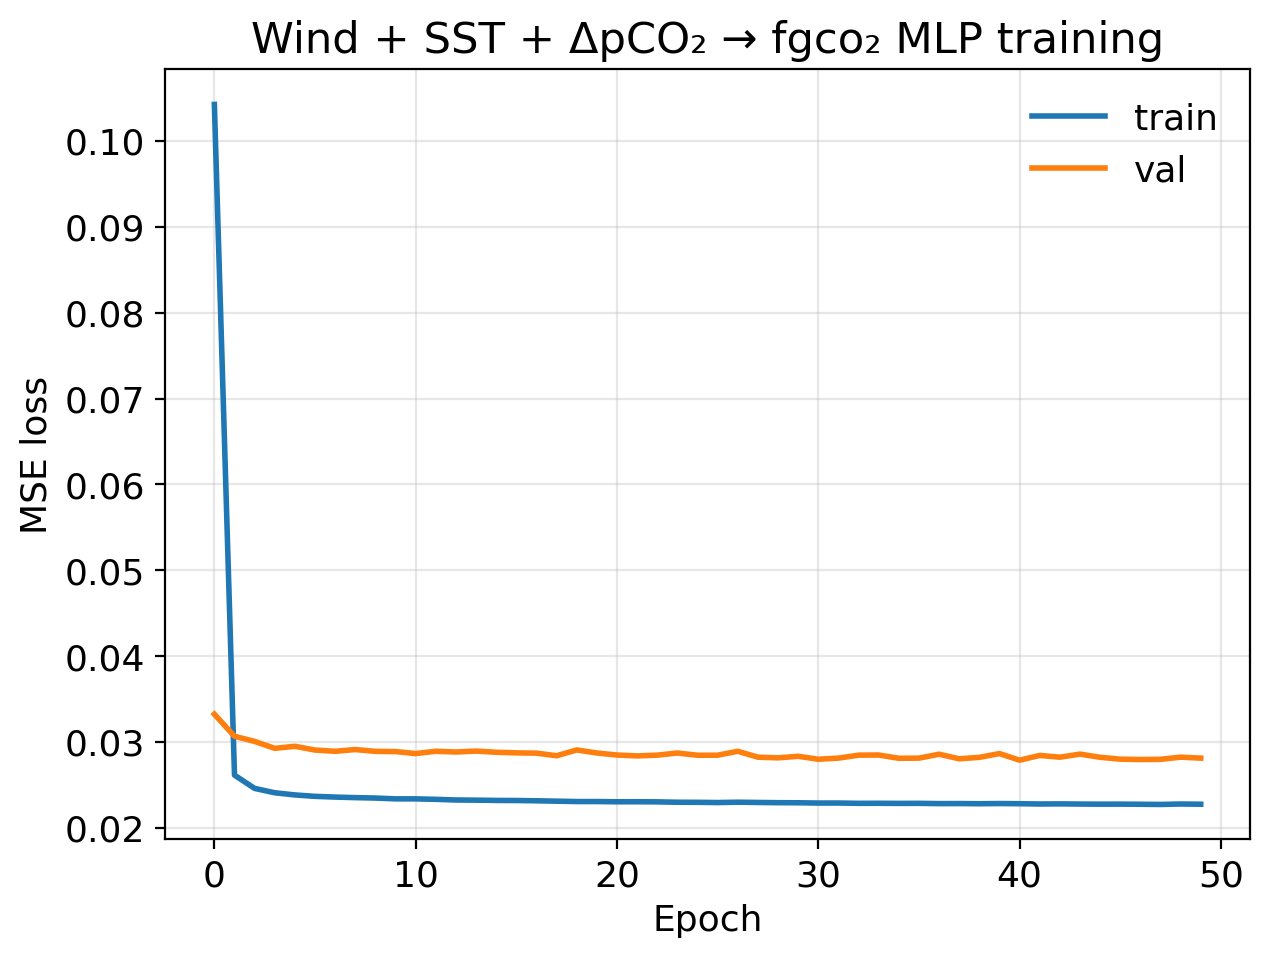

In [16]:
plt.figure(figsize=(7,5))
plt.plot(train_losses, label="train", linewidth=2)
plt.plot(val_losses,   label="val",   linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.title("Wind + SST + ΔpCO₂ → fgco₂ MLP training")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Test RMSE: 0.1562
Test R²  : 0.9862


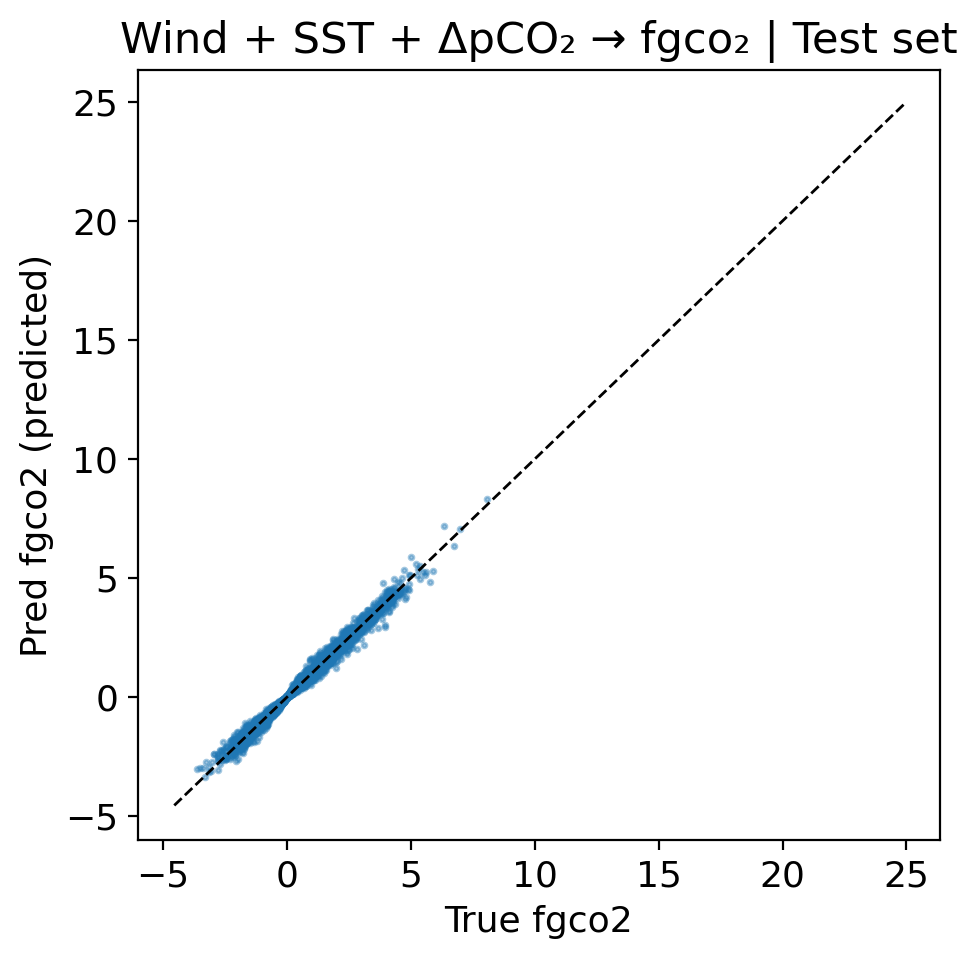

In [17]:
model_mv.eval()
with torch.no_grad():
    y_pred_test = model_mv(X_test_t.to(device)).cpu().numpy()

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test   = r2_score(y_test, y_pred_test)

print(f"Test RMSE: {rmse_test:.4f}")
print(f"Test R²  : {r2_test:.4f}")

# 随机抽一部分点画散点图（避免太密）
n_points = len(y_test)
idx = np.random.choice(n_points, size=5000, replace=False) if n_points > 5000 else np.arange(n_points)

plt.figure(figsize=(5,5))
plt.scatter(y_test[idx], y_pred_test[idx], s=3, alpha=0.4)
plt.xlabel("True fgco2")
plt.ylabel("Pred fgco2 (predicted)")
plt.title("Wind + SST + ΔpCO₂ → fgco₂ | Test set")
min_v = min(y_test.min(), y_pred_test.min())
max_v = max(y_test.max(), y_pred_test.max())
plt.plot([min_v, max_v], [min_v, max_v], "k--", linewidth=1)
plt.tight_layout()
plt.show()
